# 1 Knapsack Problem

The knapsack problem is one of the most trivial NP-hard problems. We can encounter many of its variants in the literature, which generally have various solution requirements for the algorithm. The formulation always contains criterium for the overall price, which means it is an optimization problem.

## 1.1 Author of Report

* **Name:** Tomáš Patro
* **Username:** patrotom
* **Email:** patrotom@fit.cvut.cz

## 1.2 Base of Problem

We are given

* integer $n$ (number of items)
* integer $M$ (capacity of knapsack)
* finite set $V = \{v_1, v_2, \dots, v_n\}$ (weights of items)
* finite set $C = \{c_1, c_2, \dots, c_n\}$ (prices of items)

## 1.3 Construction 0/1 Problem Form

The most well-known is the construction form. If we talk about the “knapsack problem” without a further description, we usually mean this version:

Construct the set $X = \{x_1, x_2, \dots, x_n\}$ where each $x_i$ is either $0$ or $1$, so $$v_1x_1 + v_2x_2 + \dots + v_nx_n \leq M \text{(knapsack is not overloaded)}$$ and expression $$c_1x_1 + c_2x_2 + \dots + c_nx_n$$ gains maximal value for all given sets (value of the items in the knapsack is maximal).

<br>

(“B201-NI-KOP: Problém Batohu (Knapsack Problem)” 2020)

# 2 Solution approaches

In the following section, we will describe approaches (algorithms) to solve the given problem:

* Brute force
* Branch and bound (B&B)
* Greedy heuristic
* Redux heuristic
* Dynamic programming (decomposition by weight and price)
* FPTAS algorithm

Brute force, B&B, and dynamic programming algorithms find the optimal price. Greedy, redux, and FPTAS algorithms may not found the optimal price, and we track the relative error of the computation. We compare the found price with the optimal price from the given solution files.

## 2.1 Brute Force

In the brute force approach, we search the whole state space to find the optimal price and configuration.

Let us look at the code snippet of the algorithm:

``` python
def brute_force(conf, i, weight, price):
    if i == instance.size:
        if price >= solution.price and weight <= instance.capacity:
            solution.price = price
            solution.conf = conf
        return

    new_weight = instance.items[i].weight + weight
    new_price = instance.items[i].price + price

    conf[i] = 1
    brute_force(conf, i + 1, new_weight, new_price)

    conf[i] = 0
    brute_force(conf, i + 1, weight, price)
```

The algorithm starts by comparing the current depth of the recursion `i` with the size of the instance. We use to comparison to determine if we have already solved one of the branches of recursion. If the `price` is greater or equal to the current optimal price and the `weight` is less than or equal to the knapsack capacity, we update the `solution` object with the new values – `price` and vector configuration `conf`.

Next, we compute a new weight by adding the current weight to the particular items' weight. To cover the whole state space, we have to call the recursion with the current bit set to either $0$ or $1$. We also have to recalculate the price and weight. We later send them the recursion if the bit is set to $1$ – it means that the item is added to the knapsack. In this way, we construct the whole state space and find the optimal solution.

## 2.2 Branch and Bound (B&B)

The beginning of the B&B algorithm is the same as in the brute force algorithm. The only difference is in the condition we use for the cutting of the recursion calls (state space). Let us take a look at the difference in the algorithm:

``` python
def branch_and_bound(conf, i, weight, price):
    if i == instance.size:
        if price >= solution.price:
            solution.price = price
            solution.conf = conf
        return
    
    new_weight = instance.items[i].weight + weight
    new_price = instance.items[i].price + price
    upper_bound = price + instance.prices_sum(i=i)

    conf[i] = 1
    if (new_weight <= instance.capacity) and (upper_bound > solution.price):
        branch_and_bound(conf, i + 1, new_weight, new_price)

    conf[i] = 0
    branch_and_bound(conf, i + 1, weight, price)
```

We add the condition by checking if the current `price` added to the sum of prices of the unvisited items (on the index `i` and greater) is greater than the current optimal price. We also check if the `new_weight` does not overload the knapsack. We can cut the recursion branch if we do not meet this condition. This way, we cut the branches of the state space, which do not lead us to the optimal price and valid solution.

## 2.3 Greedy Heuristic

We implement a simple heuristic using the relation between the price and weight. Let us take a look at the algorithm:

``` python
def greedy():
    instance.sort_items()
    capacity = instance.capacity
    price = 0

    for item in instance.items:
        if capacity >= item.weight:
            price += item.price
            capacity -= item.weight
            solution.conf[item.index] = 1
    
    solution.price = price
```

We start by sorting the items in descending order by $price/weight$ ratio. Then we iterate the items in this order. We check if the current capacity is greater or equal to the current items' weight in each iteration. If we meet this condition, we add the items' price to the overall price and lowers the capacity by the items' weight. We also update the configuration because we know that the item will be present in the result.

## 2.4 Redux Heuristic

Since we can encounter a situation where, for example, the last item alone would give us the optimal solution, we enhance the greedy heuristic in the following fashion:

``` python
def redux():
    greedy = Greedy()
    greedy.solve()
    highest_price, index = find_highest_price()

    if greedy.solution.price > highest_price:
        solution.price = greedy.solution.price
        solution.conf = greedy.solution.conf
    else:
        solution.price = highest_price
        solution.conf[index] = 1

def find_highest_price():
    highest_price = 0
    index = -1
    for item in instance.items:
        if item.price > highest_price and item.weight <= instance.capacity:
            highest_price = item.price
            index = item.index
    
    return (highest_price, index)
```

First, we calculate the price using the greedy algorithm. Next, we find the highest price of an item that does not overload the knapsack. Then, we compare the price found by the greedy algorithm with the highest price – the solution depends on the price, which is higher.

## 2.5 Dynamic Programming

Dynamic programming is always connected with a decomposition. We implement the following two decompositions by the overall:

* weight
* price

### 2.5.1 Weight Decomposition

The subproblems are re-evaluated, and the problem has overlapping subproblems property. We can take advantage of the dynamic programming by constructing a temporary 2D array `table` in a bottom-up manner:

``` python
def dynamic_by_weight():
    capacity = instance.capacity
    size = instance.size
    table = [[0 for x in range(capacity + 1)] for x in range(size + 1)]

    for i in range(size + 1):
        for w in range(capacity + 1):
            weight = instance.items[i - 1].weight
            price = instance.items[i - 1].price

            if i == 0 or w == 0:
                table[i][w] = 0
            elif weight <= w:
                table[i][w] = max(
                    price + table[i - 1][w - weight],
                    table[i - 1][w]
                )
            else:
                table[i][w] = table[i - 1][w]

    solution.price = table[size][capacity]
    solution.conf = construct_conf(capacity)

def construct_conf():
    conf = []

    for i in range(instance.size, 0, -1):
        if table[i][capacity] == table[i - 1][capacity]:
            conf.append(0)
        else:
            conf.append(1)
            capacity -= inst.items[i - 1].weight

    conf.reverse()

    return conf
```

In this solution, we take an approach where we compare the situation where the $n$th item is in the solution and when it is not. When we compare these two situations, we determine whether the item should or should not be in the solution. We repeat this process unless we encounter trivial subproblems. This approach leads us to an optimal solution. Afterward, we iterate over the table in a backward fashion to reconstruct the optimal solution's configuration.

### 2.5.2 Price Decomposition

Decomposition by the price is in a way similar to the decomposition by the weight. We change the `table`, so the sum of the prices composes the rows. Columns are composed of the items themselves. We can formalize the `table` in the following fashion:

$table(0,0) = 0$

$table(0, price) = \infty, \forall price > 0$

$table(i+1, price) = min(table(i, price), table(i, price - price_{i+1}) + weight_{i+1}), \forall i > 0$

``` python
def dynamic_by_price():
    prices_sum = instance.prices_sum()
    rows, cols = (prices_sum + 1, instance.size + 1)
    prepare_table(rows, cols)

    for i in range(1, cols):
        for j in range(1, rows):
            left = table[i - 1][j]
            left_b = table[i - 1][j - instance.items[i - 1].price]
            table[i][j] = min(
                left,
                left_b + instance.items[i - 1].weight
            )

    solution.price = find_optimal_price(prices_sum)
    solution.conf = construct_conf(solution.price)

def prepare_table():
    table = [
        [None if x > 0 else 0 for x in range(rows)] if x > 0 \
            else [infinity if x > 0 else 0 for x in range(rows)] \
                for x in range(cols)
    ]

def find_optimal_price(prices_sum):
    price = 0

    for i, w in enumerate(reversed(table[instance.size])):
        if w is not None and 0 < w <= instance.capacity:
            price = prices_sum - i
            break
    
    return price

def construct_conf(price):
    conf = []

    for i in range(instance.size, 0, -1):
        if table[i][price] == table[i - 1][price]:
            conf.append(0)
        else:
            conf.append(1)
            price -= instance.items[i - 1].price

    conf.reverse()

    return conf
```

We start by preparing the temporary 2D array `table`. Then, we iterate over this 2D array and fill it with the values which enable us to find the optimal price. Afterward, we find the optimal price by iterating over the prepared `table`. We reconstruct the configuration in a similar fashion as in the decomposition by the weight.

## 2.6 FPTAS Algorithm

Let us define:

* $P(S)$ optimal value criterium of the solution $S$
* $APR(I)$ approx. solution of the instance $I$
* $OPT(I)$ optimal solution of the instance $I$

$APR$ has a relative quality $R$, if

* $\forall I: R \geq max\{\frac{P(APR(I))}{P(OPT(I))}, \frac{P(OPT(I)}{P(APR(I))}\}$.

$APR$ has a relative error $\epsilon$, if

* $\forall I: \epsilon \geq max\{\frac{|P(APR(I)) - P(OPT(I))|}{max\{P(OPT(I)),P(APR(I))\}}\}$

$APR$, which $\forall \epsilon: 1 \geq \epsilon \gt 0$ solves each instance of the problem with the maximal relative error $\epsilon$ in polynomial time $|I|$ as instance size, we call **Polynomial Time Approximation Scheme (PTAS)**.

PTAS, which time depends polynomially on $\frac{1}{\epsilon}$ we call **Fully Polynomial Approximation Scheme (FTPAS)**.

Based on the formal description above, we implement the algorithm in the following fashion:

``` python
def fptas():
    max_price = max(instance.items, key=lambda x: x.price).price
    k = (instance.epsilon * max_price) / instance.size
    original_prices = list(map(lambda x: x.price, instance.items))
    instance.floor_prices(k)

    dynamic_price = DynamicPrice()
    dynamic_price.solve()

    solution.conf = dynamic_price.solution.conf
    solution.time = dynamic_price.solution.time
    solution.price = sum(
        [p for i, p in enumerate(original_prices) if solution.conf[i] == 1]
    )
```

We start by calculating the maximum price of the items. Then, we calculate the approximation variable of $k$. We floor the prices of the instance using the variable $k$. In the situation when $k$ is greater than the items' price, we set the item price to $1$ to eliminate errors related to the $0$ price of an item.

We compute the optimal price using the floored prices and dynamic programming decomposed by price. Then, we calculate the resulting price by iterating over the solution configuration using the original prices.

# 3 Results Analysis

We analyze the data using the *Python* language and its mathematical modules. The graphs and the whole report are rendered in the *Jupyter Notebook* – that's why we also add the code snippets in this report, which process data and generate the graphs. Data generated by the solution code are stored in the CSV format files, so we can easily load and process them.

We start by loading and processing the data:

In [1]:
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [2]:
# Helper functions and configuration

plt.rcParams['figure.figsize'] = (16, 9)

# Graph config
def bar_plot(ax, data, colors=None, total_width=0.8, single_width=1, legend=True):
    if colors is None:
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    n_bars = len(data)
    bar_width = total_width / n_bars
    bars = []

    for i, (name, values) in enumerate(data.items()):
        x_offset = (i - n_bars / 2) * bar_width + bar_width / 2
        for x, y in enumerate(values):
            bar = ax.bar(x + x_offset, y, width=bar_width * single_width, color=colors[i % len(colors)])
            height = bar[0].get_height()
            ax.annotate('{}'.format(height),
                        xy=(bar[0].get_x() + bar[0].get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')
        
        bars.append(bar[0])

    if legend:
        ax.legend(bars, data.keys())

# Graphs init
def time_graph(times, ax, alg):
    data = {
        f"Greedy ({alg})": times["gh"],
        f"B&B ({alg})": times["bb"],
        f"Dynamic Price ({alg})": times["dp"],
        f"Brute Force ({alg})": times["bf"],
    }
    
    labels = ["4", "10", "15", "20", "22"]
    x = np.arange(len(labels))

    ax.set_title(f"Average execution time by instance size ({alg})")

    ax.set_ylabel("Execution time [μs]")
    ax.set_xlabel("Instance size")
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    plt.yscale("log")

    bar_plot(ax, data, total_width=.8, single_width=.9)

def heuristic_graph(rel_errs, ax, mean=True):
    data = {
        "Greedy (NK)": rel_errs["NK"]["gh"],
        "Redux (NK)": rel_errs["NK"]["rgh"],
        "Greedy (ZKC)": rel_errs["ZKC"]["gh"],
        "Redux (ZKC)": rel_errs["ZKC"]["rgh"],
        "Greedy (ZKW)": rel_errs["ZKW"]["gh"],
        "Redux (ZKW)": rel_errs["ZKW"]["rgh"],
    }
    
    labels = ["4", "10", "15", "20", "22"]
    x = np.arange(len(labels))
    
    prefix = "Average" if mean else "Maximal"

    ax.set_title(f"{prefix} relative error by instance size")

    ax.set_ylabel("Relative error [‰]")
    ax.set_xlabel("Instance size")
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    plt.yscale("linear")

    bar_plot(ax, data, total_width=.8, single_width=.9)

def fptas_time_graph(times, ax, alg):
    data = {
        f"e=0.01": times[0.01],
        f"e=0.05": times[0.05],
        f"e=0.1": times[0.1],
        f"e=0.15": times[0.15],
        f"e=0.2": times[0.2],
    }
    
    labels = ["4", "10", "15", "20", "22"]
    x = np.arange(len(labels))

    ax.set_title(f"Average execution time by instance size ({alg})")

    ax.set_ylabel("Execution time [ms]")
    ax.set_xlabel("Instance size")
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    plt.yscale("log")

    bar_plot(ax, data, total_width=.8, single_width=.9)

def fptas_errs_graph(errs, ax, alg):
    data = {
        f"e=0.01": errs[0.01],
        f"e=0.05": errs[0.05],
        f"e=0.1": errs[0.1],
        f"e=0.15": errs[0.15],
        f"e=0.2": errs[0.2],
    }
    
    labels = ["4", "10", "15", "20", "22"]
    x = np.arange(len(labels))

    ax.set_title(f"Maximal real relative error by instance size ({alg})")

    ax.set_ylabel("Real relative error [‰]")
    ax.set_xlabel("Instance size")
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    plt.yscale("linear")

    bar_plot(ax, data, total_width=.8, single_width=.9)

def dynamic_graph(times, ax, alg):
    data = {
        f"Dynamic Price ({alg})": times["dp"],
        f"Dynamic Weight ({alg})": times["dw"],
    }
    
    labels = ["4", "10", "15", "20", "22"]
    x = np.arange(len(labels))

    ax.set_title(f"Average execution time by instance size ({alg})")

    ax.set_ylabel("Execution time [ms]")
    ax.set_xlabel("Instance size")
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    plt.yscale("log")

    bar_plot(ax, data, total_width=.8, single_width=.9)
    
# Data loading
def load_time_data():
    time_data = {
        "NK": {"bf": [], "bb": [], "dp": [], "gh": []},
        "ZKC": {"bf": [], "bb": [], "dp": [], "gh": []},
        "ZKW": {"bf": [], "bb": [], "dp": [], "gh": []},
    }

    for v in ["NK", "ZKC", "ZKW"]:
        for t in ["bf", "bb", "dp", "gh"]:
            for n in [4, 10, 15, 20, 22]:
                df = pd.read_csv(f"../data/output/{v}/{t}/{v}{n}_out.csv", sep=";", dtype={"time": float})
                time_data[v][t].append(float("{:.2f}".format(df.time.mean() * 1000000)))
    
    return time_data

def load_heuristic_data():
    rel_errs_data_means = {
        "NK": {"gh": [], "rgh": []},
        "ZKC": {"gh": [], "rgh": []},
        "ZKW": {"gh": [], "rgh": []},
    }
    rel_errs_data_maxes = copy.deepcopy(rel_errs_data_means)
    
    for v in ["NK", "ZKC", "ZKW"]:
        for t in ["gh", "rgh"]:
            for n in [4, 10, 15, 20, 22]:
                df = pd.read_csv(f"../data/output/{v}/{t}/{v}{n}_out.csv", sep=";", dtype={"rel_err": float})
                rel_errs_data_means[v][t].append(float("{:.2f}".format(df.rel_err.mean() * 1000)))
                rel_errs_data_maxes[v][t].append(float("{:.2f}".format(df.rel_err.max() * 1000)))

    return rel_errs_data_means, rel_errs_data_maxes

def load_fptas_time_data():
    fptas_time_data = {
        "NK": { 0.01: [], 0.05: [], 0.1: [], 0.15: [], 0.2: [] },
        "ZKC": { 0.01: [], 0.05: [], 0.1: [], 0.15: [], 0.2: [] },
        "ZKW": { 0.01: [], 0.05: [], 0.1: [], 0.15: [], 0.2: [] },
    }

    for v in ["NK", "ZKC", "ZKW"]:
        for e in [0.01, 0.05, 0.1, 0.15, 0.2]:
            for n in [4, 10, 15, 20, 22]:
                df = pd.read_csv(f"../data/output/{v}/fptas/{e}/{v}{n}_out.csv", sep=";", dtype={"time": float})
                fptas_time_data[v][e].append((float("{:.2f}".format(df.time.mean() * 1000))))

    return fptas_time_data

def load_fptas_rel_errs_data():
    fptas_rel_errs_data = {
        "NK": { 0.01: [], 0.05: [], 0.1: [], 0.15: [], 0.2: [] },
        "ZKC": { 0.01: [], 0.05: [], 0.1: [], 0.15: [], 0.2: [] },
        "ZKW": { 0.01: [], 0.05: [], 0.1: [], 0.15: [], 0.2: [] },
    }

    for v in ["NK", "ZKC", "ZKW"]:
        for e in [0.01, 0.05, 0.1, 0.15, 0.2]:
            for n in [4, 10, 15, 20, 22]:
                df = pd.read_csv(f"../data/output/{v}/fptas/{e}/{v}{n}_out.csv", sep=";", dtype={"rel_err": float})
                fptas_rel_errs_data[v][e].append((float("{:.2f}".format(df.rel_err.max() * 1000))))

    return fptas_rel_errs_data

def load_dynamic_data():
    dynamic_data = {
        "NK": {"dp": [], "dw": []},
        "ZKC": {"dp": [], "dw": []},
        "ZKW": {"dp": [], "dw": []},
    }

    for v in ["NK", "ZKC", "ZKW"]:
        for t in ["dp", "dw"]:
            for n in [4, 10, 15, 20, 22]:
                df = pd.read_csv(f"../data/output/{v}/{t}/{v}{n}_out.csv", sep=";", dtype={"time": float})
                dynamic_data[v][t].append(float("{:.2f}".format(df.time.mean() * 1000)))
    
    return dynamic_data

In [3]:
time_data = load_time_data()
rel_errs_data_means, rel_errs_data_maxes = load_heuristic_data()
fptas_time_data = load_fptas_time_data()
fptas_rel_errs_data = load_fptas_rel_errs_data()
dynamic_data = load_dynamic_data()

## 3.1 Execution Time Analysis

We measured the execution time for each run of the algorithm and saved the data to the CSV files. All execution times in this report were measured using the Python `timeit` module, which measures CPU time. The times you see in the following graphs are represented in **microseconds \[μs\]**.

Computer configuration:

* **CPU:** Intel(R) Core(TM) i5-8265U CPU @ 1.60GHz
* **OS:** Linux Mint 19.2
* **Linux kernel:** 5.4.0-48-generic 

We compared the execution times between these algorithms:

* Brute force
* Branch and bound
* Dynamic programming (decomposition by price)
* Greedy heuristic

We can use this data to see how is the execution time affected by the version of the algorithm and the instance size $n$. We look at the average execution times. For the readability purpose, we generate a separate graph for each data set:

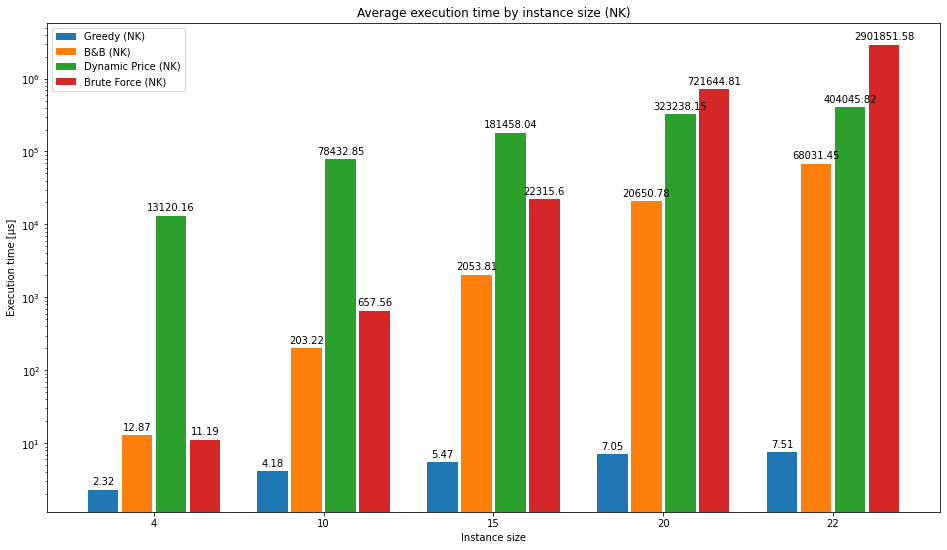

In [4]:
fig, ax = plt.subplots()
time_graph(time_data["NK"], ax, "NK")
plt.show()

The graph above shows that the **greedy heuristic** algorithm is much faster than the rest of the algorithms for the **NK** data set. It also keeps almost the same execution time for all instance sizes. **B&B** algorithm successfully cuts the state space and is faster than the **brute force** version. **B&B** is a little bit slower than the **brute force** on the instance size $4$. However, the difference is minimal, and we can conclude that it is probably the effect of execution time measuring and its precision.   

Interestingly, the **dynamic** version starts to be more effective from the instance size $20$ than the **brute force** version. However, the **B&B** version is more effective for this data set than both **brute force** and **dynamic** versions.

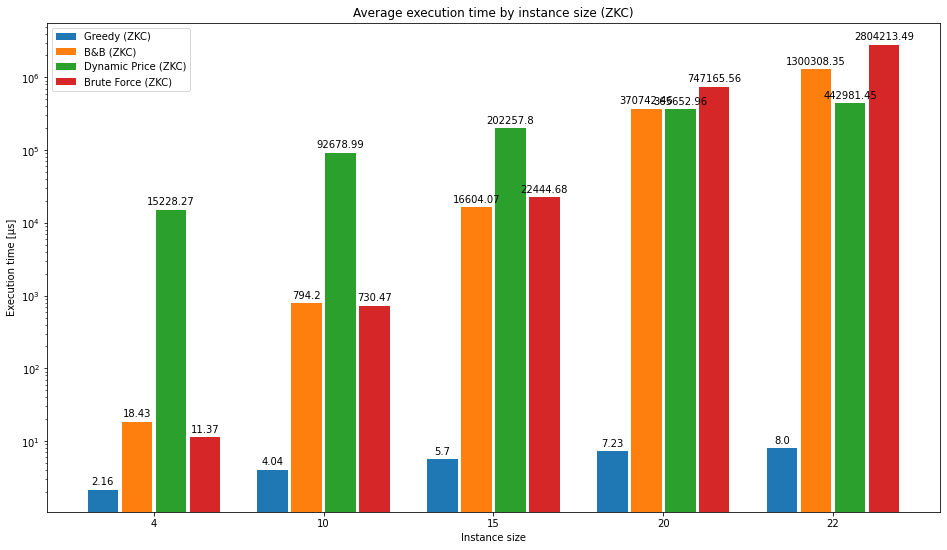

In [5]:
fig, ax = plt.subplots()
time_graph(time_data["ZKC"], ax, "ZKC")
plt.show()

Again, we can observe that the **greedy heuristic** algorithm is the fastest for the **ZKC** data set. Interestingly, the **B&B** algorithm successfully cuts the state space, but the difference is not that significant. Finally, we can see that the **dynamic** version starts to be more effective and faster from the instance size $20$ and above.

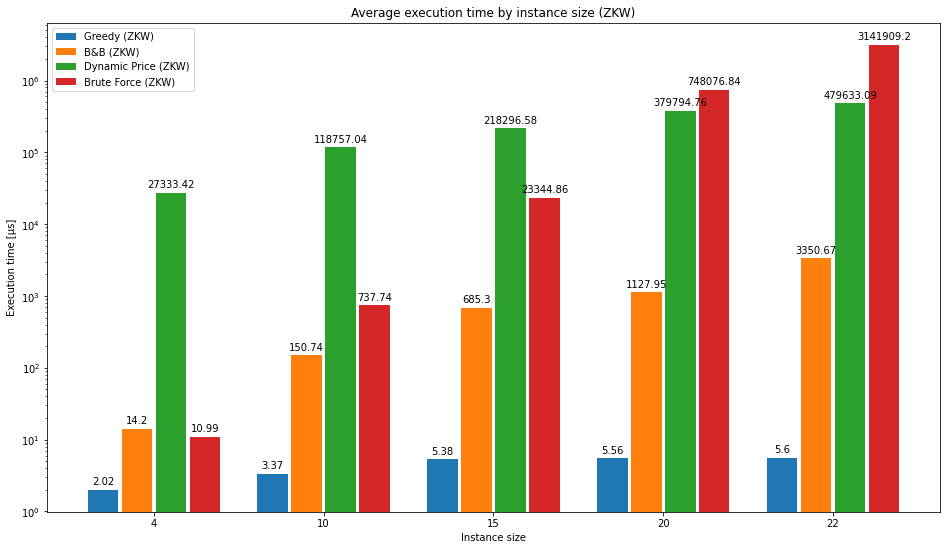

In [6]:
fig, ax = plt.subplots()
time_graph(time_data["ZKW"], ax, "ZKW")
plt.show()

Yet again, the **greedy heuristic** version remains the fastest for the **ZKW** data set. We can observe that the **B&B** version is faster than the **brute force** and dynamic versions. Interestingly, the **dynamic** version starts to be faster than the **brute force** version from the instance size $20$ and above. However, the **B&B** version keeps faster and more effective than the **dynamic** version. We can conclude that the **dynamic** version's effectivity depends on the nature of the input data we provide.

## 3.2 Heuristic Algorithms Relative Errors Comparison

In the following section, we compare the relative errors of both heuristics – greedy and redux. Given:

* calculated price $P$
* optimal price $O$

We calculate the relative error $\epsilon$ as: $$\epsilon = \frac{|P - O|}{max\{O, P\}}$$

We observe the relation between the average relative error $\epsilon$ on the instance size $n$ and the instance size itself. In the graph below, we show the relative error **per mille ‰**.

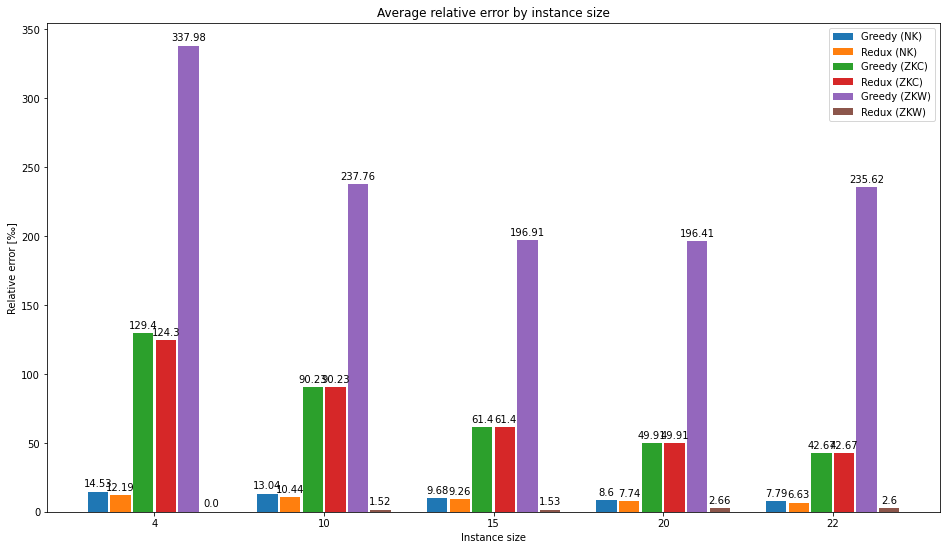

In [7]:
fig, ax = plt.subplots()
heuristic_graph(rel_errs_data_means, ax, mean=True)
plt.show()

From the graph above, we can observe some interesting facts. The **redux** heuristic slightly lowers the average relative errors for the data sets **NK** and **ZKC**. However, the difference is not significant. We can see a significant difference when we look at the **ZKW** data set.

From the data, we can conclude that the **redux** heuristic minimizes the average relative error comparing to the **greedy** heuristic on the **ZKW** data set. The **ZKW** data set is probably composed of the items where one of the last items gives the optimal solution. Therefore, the **redux** heuristic significantly minimizes the relative error.

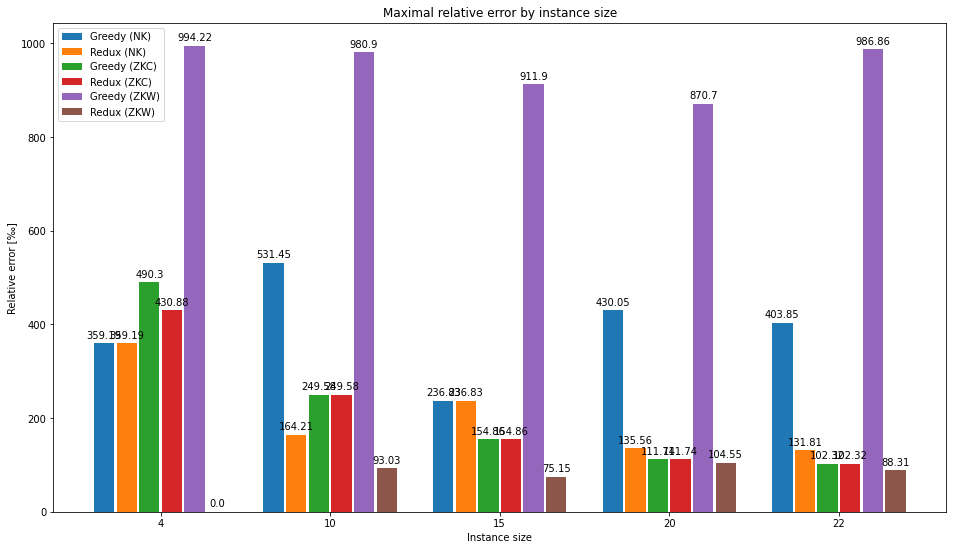

In [8]:
fig, ax = plt.subplots()
heuristic_graph(rel_errs_data_maxes, ax, mean=False)
plt.show()

When we look at the maximal relative errors, we can see that **redux** heuristic reduces the maximal relative error on the **NK** data set for the instance sizes $10$, $15$, and $20$. Other data sets and instance sizes behave similarly to the graph with the average relative errors.

## 3.3 FPTAS Algorithm Analysis

In the following section, we look at the relation between the theoretical relative error $\epsilon$, real relative error, and the execution time. We used these theoretical relative errors: $\{0.01, 0.05, 0.1, 0.15, 0.2\}$

Relative errors are calculated in the same fashion as described in **section 3.2**. For the readability purpose, we created a separate graph for each data set. In the graphs below, we show the relative errors **per mille \[‰\]** and execution times in **milliseconds \[ms\]**.

### 3.3.1 Average Execution Times

First, let us take a look at the relation between the theoretical relative error $\epsilon$, execution time, and instance size at the **NK** data set:

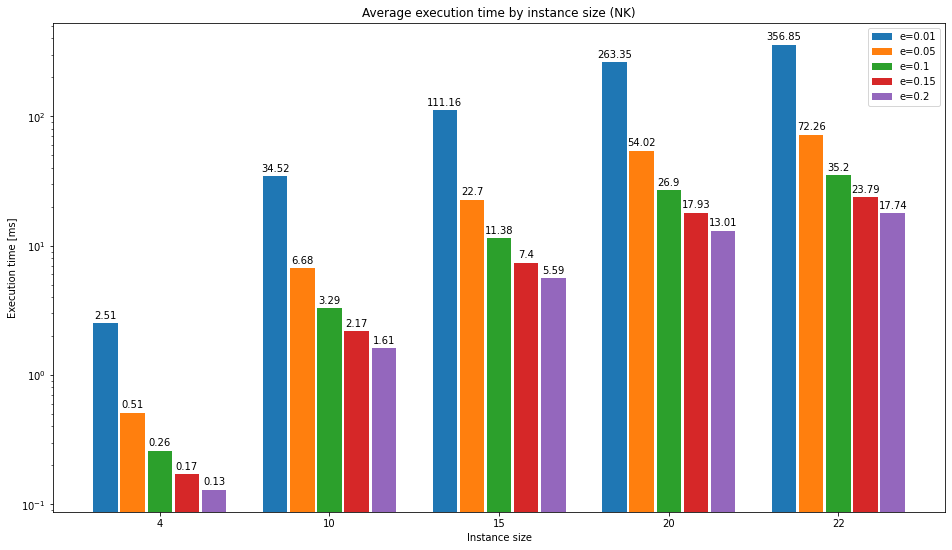

In [9]:
fig, ax = plt.subplots()
fptas_time_graph(fptas_time_data["NK"], ax, "NK")
plt.show()

From the graph above, we can see a descending trend of the execution times. If we higher $\epsilon$, the execution time lowers for all instance sizes. Let us take a look if we can confirm this trend on the **ZKC** data set:

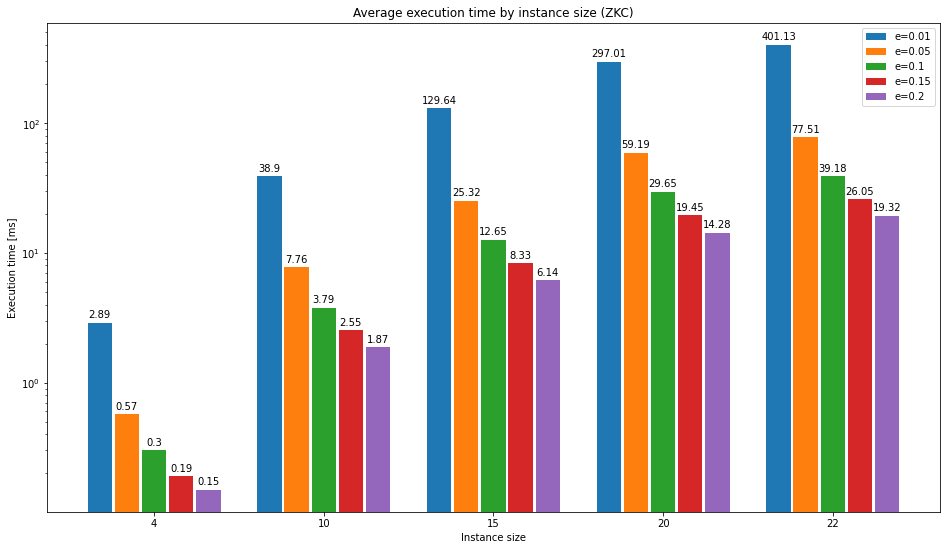

In [10]:
fig, ax = plt.subplots()
fptas_time_graph(fptas_time_data["ZKC"], ax, "ZKC")
plt.show()

Again, we can confirm the descending average execution time when we higher $\epsilon$. Finally, let's take a look at the **ZKW** data set:

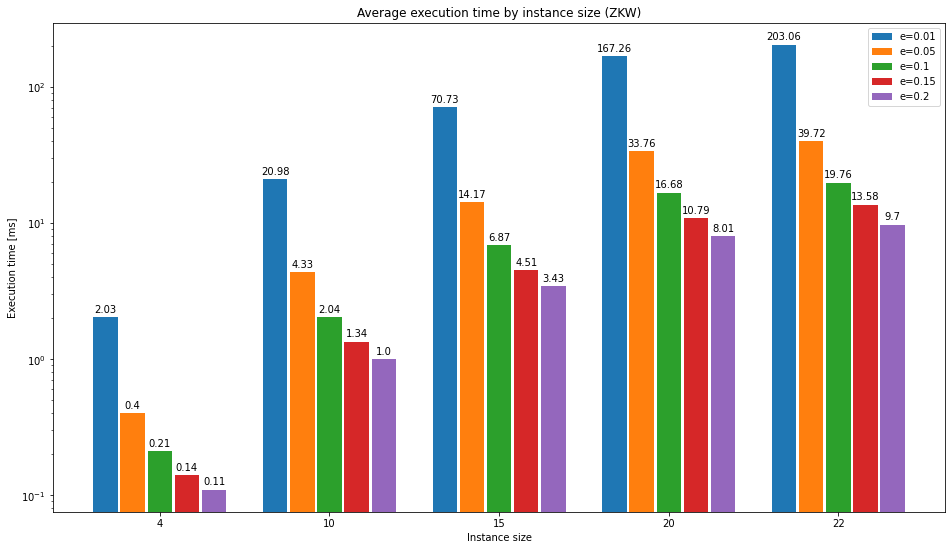

In [11]:
fig, ax = plt.subplots()
fptas_time_graph(fptas_time_data["ZKW"], ax, "ZKW")
plt.show()

Based on the three data sets results, we can conclude that the execution times lower with the rising value of $ \epsilon $. This fact holds even if we change the instance size within a data set.

### 3.3.2 Maximal Real Relative Errors

Let us look at how the theoretical relative error $\epsilon$ relates to the real relative error and the instance size. Let us start with the **NK** data set:

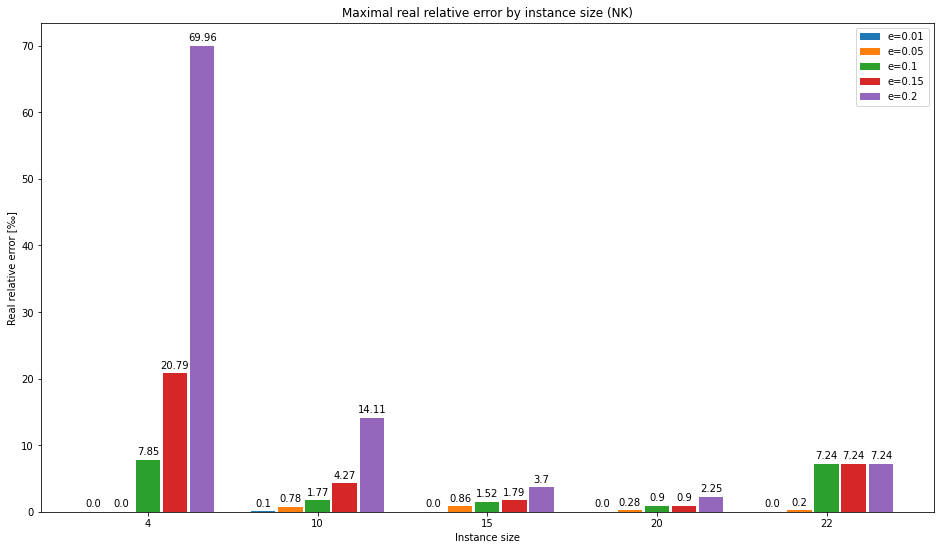

In [12]:
fig, ax = plt.subplots()
fptas_errs_graph(fptas_rel_errs_data["NK"], ax, "NK")
plt.show()

We can see that the maximal error rises if we highers the $\epsilon$ in the **NK** data set. It is most notable on the instance size $4$. This fact also relates to the instance size since it is used in the computation of the variable $k$, which we use to floor the items. The higher the instance size is, the lower the variable $k$ is, and thus, the real relative error lowers. Let us take a look at the **ZKC** data set:

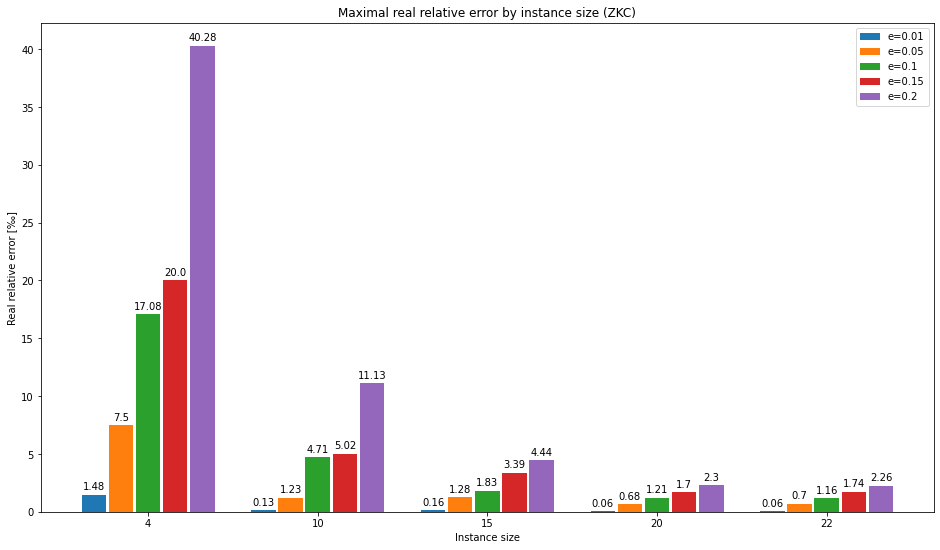

In [13]:
fig, ax = plt.subplots()
fptas_errs_graph(fptas_rel_errs_data["ZKC"], ax, "ZKC")
plt.show()

We can observe a similar behavior as in the previous data set. Here, the real relative error rises even steadier when we higher $\epsilon$. We can also observe that the error lowers when we raise the instance size. Let us take a look at the last data set **ZKW**:

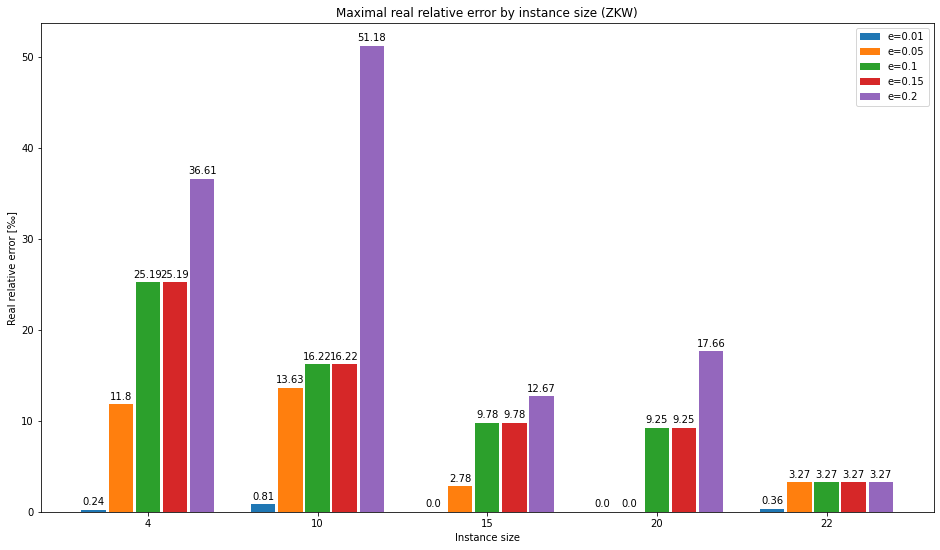

In [14]:
fig, ax = plt.subplots()
fptas_errs_graph(fptas_rel_errs_data["ZKW"], ax, "ZKW")
plt.show()

We can see slightly different behavior from the graph above than in the rest of the data sets. In many cases, a different value of $\epsilon$ yields the same real relative error values. We can conclude that we can not generalize the behavior based on the $\epsilon$ and instance size. We also have to consider the nature of the data set and the way it has been generated.

## 3.4 Dynamic Programming Decompositions Comparison

The following section will compare the execution times between the two dynamic programming algorithms – decomposition by price and weight. The execution times on the graphs are represented in **milliseconds \[ms\]**. For the readability purpose, we generate a separate graph for each data set. Let us start with the **NK** data set:

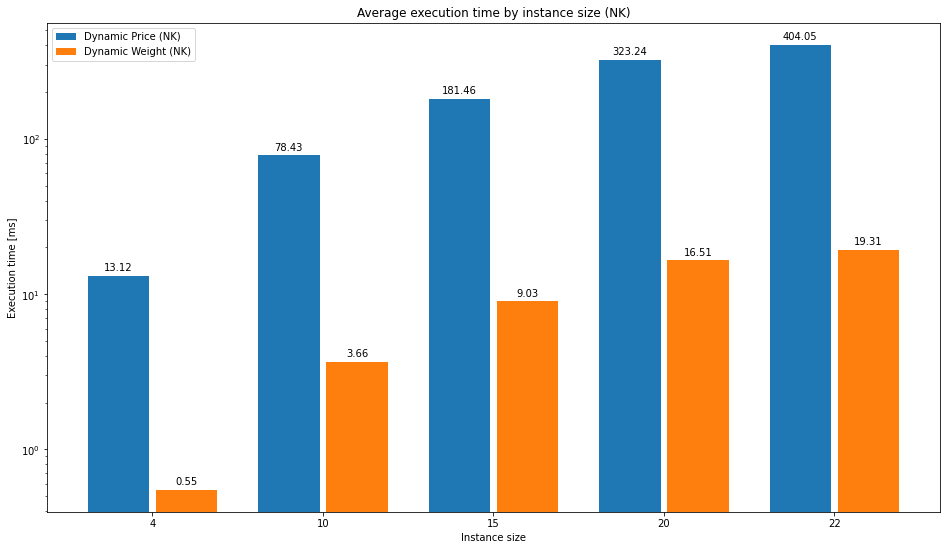

In [15]:
fig, ax = plt.subplots()
dynamic_graph(dynamic_data["NK"], ax, "NK")
plt.show()

We can observe that the decomposition by weight is significantly faster for all instance sizes. The best possible explanation is probably the considerable difference between the temporary 2D arrays in the two decompositions. It is costlier to construct and iterate over the array for the price decomposition for the **NK** data set – the tables are much bigger than in the weight decomposition version.

Let us take a look at the **ZKC** data set:

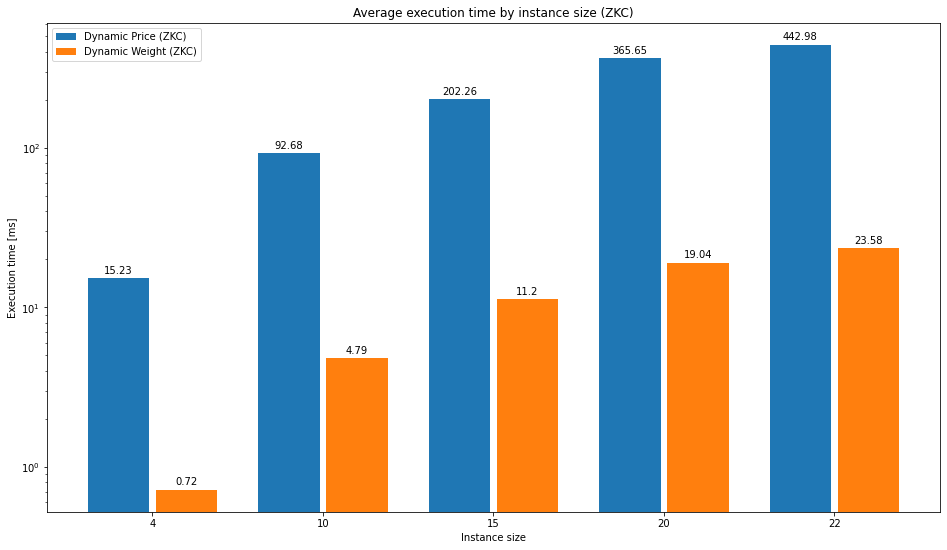

In [16]:
fig, ax = plt.subplots()
dynamic_graph(dynamic_data["ZKC"], ax, "ZKC")
plt.show()

Again, we can observe that the decomposition by weight is faster than the price version. The algorithms behave similarly, as in the previous data set.

Let us take a look at the **ZKW** data set:

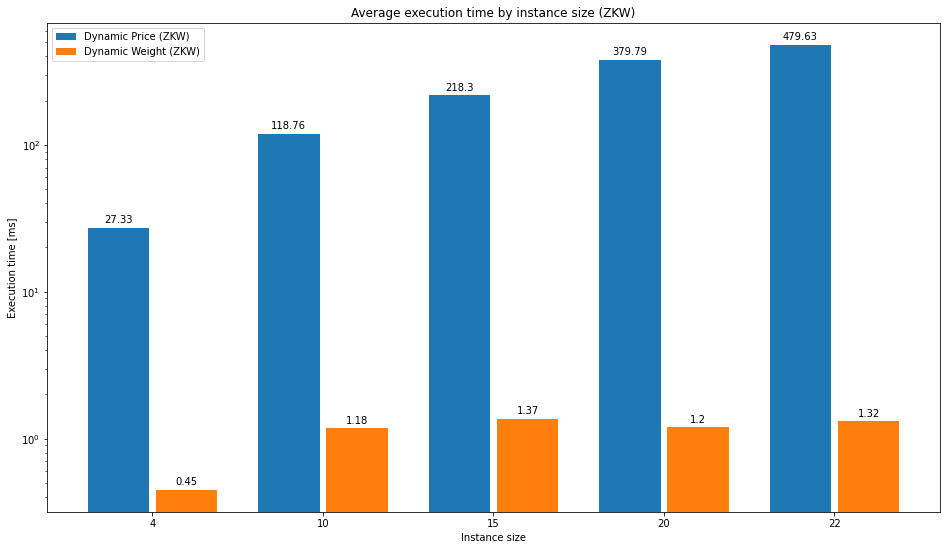

In [17]:
fig, ax = plt.subplots()
dynamic_graph(dynamic_data["ZKW"], ax, "ZKW")
plt.show()

Here, the differences between the two versions are even more significant. We can conclude that the decomposition by weight runs significantly faster on all three data sets.

# 4 Conclusion

First, we explained the base of the Knapsack problem and formally described it alongside the problem variables. We also specified the construction form of the problem we analyze in the report. Next, we described the solution approaches we analyze in the report:

* Brute force
* Branch and bound (B&B)
* Greedy and Redux heuristics
* Dynamic programming (decomposition by price and weight)
* FPTAS algorithm

In the second part of the report, we experimentally analyzed and compared the relationship between the execution times and instance size and compared these algorithms – brute force, B&B, greedy heuristic, and dynamic programming with decomposition by price. We also compared how the different algorithms behave when we use different data sets.

In the third part, we compared the relative errors of the heuristic algorithms – greedy and redux. We observed how the redux algorithm potentially reduces the relative error when we use a particular type of input data.

In the fourth part, we analyzed the FPTAS algorithm. We took several values of $\epsilon$ and observed how the value of $\epsilon$ relates to the execution time and the real relative error value. We concluded that it is very important to find a proper compromise between the size of $\epsilon$ and the algorithm's execution time.

In the last part of the report, we compared the execution times between the two dynamic programming versions – decomposition by price and weight. We observed the behavior in several data sets. We can conclude that the decomposition by weight is significantly faster on all three data sets we used.

# Bibliography

<br>

“B201-NI-KOP: Problém Batohu (Knapsack Problem).” 2020. Accessed October 31. [https://
moodle-vyuka.cvut.cz/mod/page/view.php?id=89694]().